### THIS NOTEBOOK ONLY WORKS ON COLAB (as of 19/08/2024)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Change as required
os.chdir('/Data Pipeline/Backend')

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

import cv2
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score, f1_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import clone_model, load_model

from glob import glob
import copy
import datetime
import os
import pickle as pkl

import models, utils

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Seeding
from tensorflow.compat.v1 import set_random_seed
set_random_seed(123)

import random as python_random
python_random.seed(123)

import random
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.uniform([1], seed=SEED)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.7995876], dtype=float32)>

## Helper Functions

In [ ]:
# Load data

def get_image_paths(folder_path, extensions=('jpg', 'jpeg', 'png', 'bmp')):
    image_paths = []

    # List all files in the folder
    all_files = os.listdir(folder_path)

    # Filter files based on extensions
    image_paths = [os.path.join(folder_path, file) for file in all_files if file.lower().endswith(extensions)]
    image_paths = np.sort(image_paths)

    return image_paths

In [ ]:
def save_binary_masks_as_images(X_test, binary_masks, output_folder):
    """
    Save NumPy array of binary masks as images in the specified folder.

    Parameters:
    - binary_masks: NumPy array of binary masks to save.a
    - output_folder: Path to the folder where the images will be saved.
    """
    os.makedirs(output_folder, exist_ok=True)

    for i in range(len(binary_masks)):
        label = X_test[i].split("/")[-1]
        mask = binary_masks[i]

        # Create a plot for each mask
        plt.imshow(mask[::-1], cmap='gray')  # Assuming the masks are binary (0 and 1)
        plt.axis('off')

        # Save the plot as an image
        output_file = "predicted_" + label
        output_path = os.path.join(output_folder, output_file)
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

        print(f"Saved mask {label} to {output_path}")

        plt.close()

In [ ]:
def save_resized_test_images(X_test, output_folder):
    """
    Save NumPy array of binary masks as images in the specified folder.

    Parameters:
    - binary_masks: NumPy array of binary masks to save.a
    - output_folder: Path to the folder where the images will be saved.
    """
    os.makedirs(output_folder, exist_ok=True)

    for i in range(len(X_test)):
        label = X_test[i].split("/")[-1]
        print(label)

        image = cv2.imread(X_test[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_LANCZOS4)


        # Create a plot for each mask
        plt.imshow(image)  # Assuming the masks are binary (0 and 1)
        plt.axis('off')

        # Save the plot as an image
        output_file = label
        output_path = os.path.join(output_folder, output_file)
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

        print(f"Saved image {label} to {output_path}")

        # Close the plot to release resources
        plt.close()

In [ ]:
def crop_image_with_mask(image_path, mask_path, output_path):
    # Read the image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize the mask to match the dimensions of the image
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Ensure there is at least one contour
    if len(contours) > 0:
        # Create a mask of the same size as the input image
        mask_result = np.zeros_like(mask, dtype=np.uint8)

        # Draw all contours on the mask
        cv2.drawContours(mask_result, contours, -1, 255, thickness=cv2.FILLED)

        # Bitwise AND operation to get the cropped region
        cropped_image = cv2.bitwise_and(image, image, mask=mask_result)

        # Save the result
        cv2.imwrite(output_path, cropped_image)
        print(f"Cropped image saved to {output_path}")
    else:
        print("No contours found in the mask.")

In [ ]:
def image_contours(mask_path, contour_path):
    # Read mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    mask_shape = mask.shape

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return "Error: No contours found in the mask"

    multiple_contours = {}
    multiple_contours["Mask_shape"] = mask_shape

    for n, contour in enumerate(contours):
        key = "Contour_" + str(n + 1)

        # in case of multiple coordinates
        contour_data = {}
        contour_coordinates = []
        starting_coord = ()

        for coord in contour:
            coord_x = coord[0][0]
            coord_y = coord[0][1]
            coordinates = (coord_x, coord_y)
            contour_coordinates.append(coordinates)

            if not starting_coord:
                starting_coord = coordinates

        contour_coordinates.append(starting_coord)

        # extra check to see if start and end coord is the same as it has to be the same for shoelace formula
        start_end_coord = (contour_coordinates[0], contour_coordinates[-1])

        # Use set just in case there are originally only 2 distinct coordinates
        len_of_distinct_coordinates = len(set(contour_coordinates))

        if len_of_distinct_coordinates < 2:
            pixel_area = 0
            contour_data["pixel_area"] = pixel_area
            contour_data["start_end_coord"] = start_end_coord
            contour_data["contour_coordinates"] = contour_coordinates
            multiple_contours[key] = contour_data

        else:
            no_of_coordinates = len(contour_coordinates)
            x_coords, y_coords = zip(*contour_coordinates)

            #Shoelace formula to calculate area with coordinates
            pixel_area = 0.5 * abs(sum(x_coords[i] * y_coords[(i + 1) % no_of_coordinates] -
                                       x_coords[(i + 1) % no_of_coordinates] * y_coords[i] for i in range(no_of_coordinates)))
            contour_data["pixel_area"] = pixel_area
            contour_data["start_end_coord"] = start_end_coord
            contour_data["contour_coordinates"] = contour_coordinates
            multiple_contours[key] = contour_data

            # Draw the contours on a black image
            contour_image = np.zeros_like(mask)
            cv2.drawContours(contour_image, [contour], -1, (255), thickness = 5)
    return multiple_contours

In [ ]:
def main_mask_finder(mask_path,contour_path):

    #Largest contour is assumed to be main mask
    main_mask = {}
    max_area = 0
    image_area = 0
    max_contour = ""

    contour_result = image_contours(mask_path,contour_path)

    # result is {'Mask_shape': (576, 768)
    #            "Contour_xx":{"pixel_area":1000,
    #            "start_end_coord":((348, 39), (348, 39)),
    #            "contour_coordinates":[(X1, Y1),]}}

    #There is only 1 contour as contour result = ({Mask_shape:(length,breath),'Contour_1':{data}})

    main_mask['Mask_shape'] = contour_result['Mask_shape']
    image_area = (main_mask['Mask_shape'][0]-1) * (main_mask['Mask_shape'][1]-1)

    for i in range(1 , len(contour_result)):
        contour_i = "Contour_" + str(i)
        area = contour_result[contour_i]['pixel_area']

        #It is highly unlikely that 2 masks will have the exact same pixel area
        if area != image_area and area > max_area:
            max_area = area
            max_contour = contour_i

    main_mask[max_contour] = contour_result[max_contour]

    # plot contour
    plot_coordinates = []

    for point in main_mask[max_contour]['contour_coordinates']:
        plot_coordinates.append([point])

    plot_coordinates = np.array(plot_coordinates)

    contour_image = np.zeros(main_mask['Mask_shape'], dtype=np.uint8)
    contours = [plot_coordinates.reshape((-1, 1, 2))]
    cv2.drawContours(contour_image, contours, -1, (255), -1)

    cv2.imwrite(contour_path, contour_image)

    return main_mask

In [ ]:
def enlarged_main_mask(mask_path,save_path,enlargement_factor,new_size):

    #Largest contour is assumed to be main mask
    main_mask = {}
    max_area = 0
    image_area = 0
    max_contour = ""

    contour_result = image_contours(mask_path,contour_path)

    # result is {'Mask_shape': (576, 768)
    #            "Contour_xx":{"pixel_area":1000,
    #            "start_end_coord":((348, 39), (348, 39)),
    #            "contour_coordinates":[(X1, Y1),]}}

    #There is only 1 contour as contour result = ({Mask_shape:(length,breath),'Contour_1':{data}})

    main_mask['Mask_shape'] = contour_result['Mask_shape']
    image_area = (main_mask['Mask_shape'][0]-1) * (main_mask['Mask_shape'][1]-1)

    for i in range(1 , len(contour_result)):
        contour_i = "Contour_" + str(i)
        area = contour_result[contour_i]['pixel_area']

        #It is highly unlikely that 2 masks will have the exact same pixel area
        if area != image_area and area > max_area:
            max_area = area
            max_contour = contour_i

    main_mask[max_contour] = contour_result[max_contour]

    # plot contour
    plot_coordinates = np.array(main_mask[max_contour]['contour_coordinates'])
    centre = np.mean(plot_coordinates, axis = 0)

    translated_coords = plot_coordinates - centre
    scaled_coords = translated_coords * enlargement_factor
    enlarged_coords = scaled_coords + centre
    enlarged_coordinates = [tuple(coord) for coord in enlarged_coords]

    # Create a blank image
    mask = np.zeros(main_mask['Mask_shape'], dtype=np.uint8)
    contours = np.array([enlarged_coordinates], dtype=np.int32)

    # Draw filled contour
    cv2.drawContours(mask, [contours], -1, 255, -1)

    # plt.imshow(mask, cmap='gray')
    # plt.axis('off')
    # plt.show()
    resized_mask = cv2.resize(mask, new_size, interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(save_path, resized_mask)

## Data Loading

In [ ]:
# helper functions for to prepare data
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting wound, non-wound pixels into two categories.'''
    return keras.utils.to_categorical(target_array,2)

In [ ]:
path = '/Datasets/Segmentation Dataset'

X_train = get_image_paths(path + "/Train_image")
X_test = get_image_paths(path + "/Test_image")
X_val = get_image_paths(path + "/Val_image")
y_train = get_image_paths(path + "/Train_mask")
y_test = get_image_paths(path + "/Test_mask")
y_val = get_image_paths(path + "/Val_mask")

print(len(X_train), len(X_test), len(X_val))

2571 735 367


In [ ]:
train_input_names = X_train
train_label_names = y_train
val_input_names = X_val
val_label_names = y_val
test_input_names = X_test
test_label_names = y_test

## Model Training/Loading

In [ ]:
best_model = models.att_unet_2d((128, 128, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=2, # 2 labels, wound and non-wound
                           stack_num_down=2, stack_num_up=2, activation='ReLU',
                           atten_activation='ReLU', attention='add', output_activation='Softmax',       # changed the output activation
                           batch_norm=True, pool=True, unpool=True,
                           backbone='VGG16', weights='imagenet',
                           # Transfer learning using VGG16
                           freeze_backbone=True, freeze_batch_norm=True,
                           # freeze_backbone freeze the backbone layers during training, so that their weights are not updated during backpropagation.
                           # freeze_batch_norm keep normalization behavior fixed. Network trained more efficiently. However, it can also limit the adaptability of the model to different data distributions
                           name='attunet')

In [ ]:
best_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]
)

In [ ]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting wound, non-wound pixels into two categories.'''
    return keras.utils.to_categorical(target_array,2)

In [ ]:
valid_input = input_data_process(utils.image_to_array(X_val, size=128, channel=3))
valid_label = target_data_process(input_data_process(utils.image_to_array(y_val, size=128, channel=1)))
valid_label_visualize = utils.image_to_array(y_val, size=128, channel=1)

In [ ]:
# Note: Best model is initialized outside the loop
def train_model(best_model, folder_path, model_checkpoint, N_epoch, N_sample, tol, max_tol, min_del):
    # Check if directory exist
    if not os.path.exists(folder_path):
        print("Directory does not exist, creating ...")
        os.makedirs(folder_path)
    else:
        print("Directory exist")

    # Read in best model
    model_files = glob(os.path.join(folder_path, '*.h5'))
    model_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    if len(model_files) == 0:
        model = best_model # None
        epoch_num = 0
        print('Latest model:', model)
    else:
        latest_model_file = model_files[-1]
        epoch_num = latest_model_file.split('_')[-1].split('.')[0]
        print('Latest model:', latest_model_file.split('/')[-1])
        print(epoch_num)
        # Load best model
        model = load_model(os.path.join(folder_path, latest_model_file))

    # Read in model stats
    model_stats_path = folder_path + "model_stats.csv"
    if os.path.exists(model_stats_path):
        print("File exist")
        model_stats_df = pd.read_csv(model_stats_path)
    else:
        # if the file doesn't exist, create a new empty DataFrame
        print("File does not exist, creating ...")
        model_stats_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Validation Loss', 'Accuracy', 'Mean IOU'])

    val_loss, train_loss, acc_lst, mean_iou_lst = [],[],[],[]

    epoch_counter = int(epoch_num)
    # loop over epoches
    for epoch in range(N_epoch):
        print(f'epoch: {epoch}')

        # initial loss record
        if epoch == 0:
            y_pred = model.predict([valid_input])
            record = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
            print('\tInitial loss = {}'.format(record))


        # loop over batches
        for step in range((len(X_train)//N_sample + 1)):
            # selecting samples for the current batch
            ind_train_shuffle = utils.shuffle_ind(len(X_train))[:N_sample]

            # batch data formation
            ## augmentation is not applied
            train_input = input_data_process(utils.image_to_array(X_train[ind_train_shuffle], size=128, channel=3))
            train_label = target_data_process(input_data_process(utils.image_to_array(y_train[ind_train_shuffle], size=128, channel=1)))

            # train on batch
            loss_ = model.train_on_batch([train_input,], [train_label,])

        # epoch-end validation
        y_pred = model.predict([valid_input])
        record_temp = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
        y_pred_cat = np.array([[[[1 if j == np.argmax(pixel_arr) else 0 for j in range(len(pixel_arr))] for pixel_arr in row] for row in image] for image in y_pred])

        # calculate iou
        intersection = np.sum(np.logical_and(valid_label[:, :, :, 1], y_pred_cat[:, :, :, 1]))
        union = np.sum(np.logical_or(valid_label[:, :, :, 1], y_pred_cat[:, :, :, 1]))
        mean_iou = intersection / union
        _, accuracy = model.evaluate(valid_input, valid_label, verbose=0)

        acc_lst.append(accuracy)
        mean_iou_lst.append(mean_iou)
        train_loss.append(loss_[0])
        val_loss.append(record_temp)
        # Update counter
        epoch_counter += 1
        print(f'Counter = {epoch_counter}')

        # if loss is reduced
        if record - record_temp > min_del:
            print('Validation performance is improved from {} to {}'.format(record, record_temp))
            print(f'Mean IOU = {mean_iou}')
            record = record_temp; # update the loss record
            tol = 0; # refresh early stopping patience

            train_loss_temp = loss_[0]
            val_loss_temp = record_temp

            # save the weights of the best model
            best_model.set_weights(model.get_weights())

        # if loss not reduced
        else:
            print('Validation performance {} is NOT improved'.format(record_temp))
            print(f'Mean IOU = {mean_iou}')
            tol += 1
            if tol >= max_tol:
                print('Early stopping')
                break;
            else:
                # Pass to the next epoch
                continue;


    print(f'Saving model checkpoint: epoch num = {epoch_counter}')
    model_output_name = 'best_model_{}_{}'.format(model.name, int(epoch_counter))

    if best_model is not None:
        print(f'Saving model: {model_output_name}')
        print(int(epoch_num)-1,int(epoch_counter),len(train_loss))
        best_model.save(folder_path + model_output_name + ".h5")
        model_stats = pd.DataFrame({'Epoch':  list(range(int(epoch_num),int(epoch_counter))), 'Train Loss': train_loss, 'Validation Loss': val_loss, 'Accuracy': acc_lst, 'Mean IOU': mean_iou_lst})
    else:
        print('No best model, continue...')
        model_stats = pd.DataFrame({'Epoch':  list(range(int(epoch_num),int(epoch_counter))), 'Train Loss': train_loss, 'Validation Loss': val_loss, 'Accuracy': acc_lst, 'Mean IOU': mean_iou_lst})

    # append the model_stats DataFrame to the existing DataFrame
    model_stats_df = pd.concat([model_stats_df, model_stats], ignore_index=True)
    model_stats_df.to_csv(model_stats_path, index=False)
    return best_model, model_stats_df

In [ ]:
folder_path = "/Data Pipeline/Segmentation Checkpoints"
best_model = best_model
# Model Param
N_epoch = 100 # number of epoches
model_checkpoint = 100 # save model after every n epoches
# N_batch = 2 # number of batches per epoch
N_sample = 32 # number of samples per batch

tol = 0 # current early stopping patience
max_tol = 20 # the max-allowed early stopping patience
min_del = 0 # the lowest acceptable loss value reduction

In [ ]:
# t_model, t_stats = train_model(best_model, folder_path, model_checkpoint, N_epoch, N_sample, tol, max_tol, min_del)

In [ ]:
# Load model
checkpoint_path = folder_path + "/best_model_attunet_model_193.h5"

# only works on colab
model = load_model(checkpoint_path)

## Inference

In [ ]:
image_path = '/Data Pipeline/Datasets/Segmentation Samples'

X_test = get_image_paths(image_path)
print(len(X_test))

test_input = input_data_process(utils.image_to_array(X_test, size=128, channel=3))

y_pred = model.predict([test_input])

final_pred = np.array([[[[np.argmax(pixel_arr)] for pixel_arr in row] for row in image] for image in y_pred])

mask_folder =  image_path + "/Predictions"
os.makedirs(mask_folder,exist_ok = True)
save_binary_masks_as_images(X_test, final_pred, mask_folder)

8
1/1 [==============================] - 5s 5s/step
Saved mask CC_10.png to /content/drive/MyDrive/Work/ATAP/Data Pipeline/Datasets/Segmentation Samples/Predictions/predicted_CC_10.png
Saved mask CC_3.png to /content/drive/MyDrive/Work/ATAP/Data Pipeline/Datasets/Segmentation Samples/Predictions/predicted_CC_3.png
Saved mask CC_4.png to /content/drive/MyDrive/Work/ATAP/Data Pipeline/Datasets/Segmentation Samples/Predictions/predicted_CC_4.png
Saved mask CC_5.png to /content/drive/MyDrive/Work/ATAP/Data Pipeline/Datasets/Segmentation Samples/Predictions/predicted_CC_5.png
Saved mask CC_6.png to /content/drive/MyDrive/Work/ATAP/Data Pipeline/Datasets/Segmentation Samples/Predictions/predicted_CC_6.png
Saved mask CC_7.png to /content/drive/MyDrive/Work/ATAP/Data Pipeline/Datasets/Segmentation Samples/Predictions/predicted_CC_7.png
Saved mask CC_8.png to /content/drive/MyDrive/Work/ATAP/Data Pipeline/Datasets/Segmentation Samples/Predictions/predicted_CC_8.png
Saved mask CC_9.png to /conte

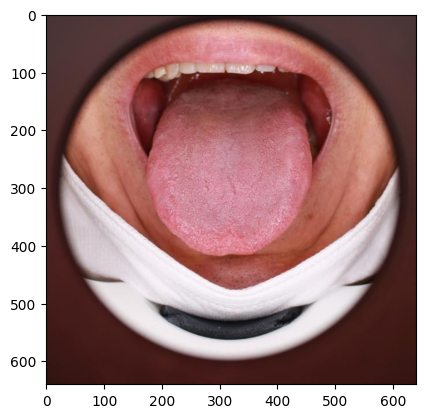

In [ ]:
image = Image.open(image_path + '/CC_10.png')
plt.imshow(image)
plt.show()

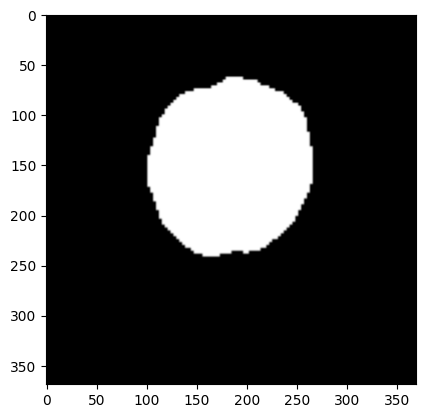

In [ ]:
image = Image.open(image_path + '/Predictions/predicted_CC_10.png')
plt.imshow(image)
plt.show()